In [1]:
import argparse
import cv2
import numpy as np 
import os
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import random

## Reading files

In [2]:
def getFiles(train, path):
    images = []
    count = 0
    for folder in os.listdir(path):
        for file in  os.listdir(os.path.join(path, folder)):
            images.append(os.path.join(path, os.path.join(folder, file)))

    if(train is True):
        np.random.shuffle(images)
    
    return images


def readImage(img_path):
    img = cv2.imread(img_path, 0)
    return cv2.resize(img,(150,150))


## Plotting Functions

In [3]:
def show_image(img,text='',dpi=120):
    
    if len(img.shape)==2:
        l,b = img.shape
    else :
        l,b,_ = img.shape
    
    fig,ax = plt.subplots()
    ax.imshow(img)
    ax.axis("off")
    plt.suptitle(text)
    plt.show()
    return 

def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plotConfusions(true, predictions):
    np.set_printoptions(precision=2)

    class_names = ["aquarium", "desert", "highway", "kitchen", "laundromat", "park", "waterfall", "windmill"]
    plotConfusionMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()


## Helper functions 

In [4]:
def getDescriptors(sift, img):
    kp, des = sift.detectAndCompute(img, None)
    return des

def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 

    return descriptors

def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features

def normalizeFeatures(scale, features):
    return scale.transform(features)


def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def findSVM(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
        features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print("gamma in this process is: ", gamma_param)
    class_weight = {
        0: 1,
        1: 1,
        2: 1,
        3: 1,
        4: 1,
        5: 1,
        6: 1,
        7:1
    }
  
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param, class_weight = class_weight)
    svm.fit(features, train_labels)
    return svm


def findAccuracy(true, predictions):
    print ('accuracy score: %0.3f' % accuracy_score(true, predictions))



## Training  

In [5]:
def trainModel(path, no_clusters, kernel):
    images = getFiles(True, path)
    print("Train images path detected.")
    sift = cv2.xfeatures2d.SIFT_create()
    descriptor_list = []
    train_labels = np.array([])
    label_count = 7
    image_count = len(images)

    for img_path in images:
        if("aquarium" in img_path):
            class_index = 0
        elif("desert" in img_path):
            class_index = 1
        elif("highway" in img_path):
            class_index = 2
        elif("kitchen" in img_path):
            class_index = 3
        elif("laundromat" in img_path):
            class_index = 4
        elif("park" in img_path):
            class_index = 5
        elif("waterfall" in img_path):
            class_index = 6
        else:
            class_index = 7

        train_labels = np.append(train_labels, class_index)
        img = readImage(img_path)
        des = getDescriptors(sift, img)
        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)
    kmeans = clusterDescriptors(descriptors, no_clusters)
    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters)
    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    plotHistogram(im_features, no_clusters)
    
    svm = findSVM(im_features, train_labels, kernel)
    
    print("Training Done!!.")

    return kmeans, scale, svm, im_features


Train images path detected.


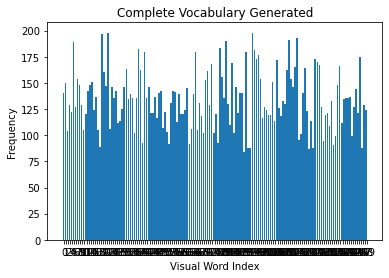

gamma in this process is:  0.1
Training Done!!.


In [6]:
tr_path = '../dataset/SUN_data/SUN_data/train'
tes_path = '../dataset/SUN_data/SUN_data/test'
no_clusters = 150
ker_type = "precomputed"
gamma = 0.1
kmeans, scale, svm, im_features = trainModel(tr_path, no_clusters, ker_type)


## Testing 

In [7]:
def testModel(path, kmeans, scale, svm, im_features, no_clusters, kernel):
    test_images = getFiles(False, path)
    print("Test images path detected.")

    count = 0
    true = []
    descriptor_list = []

    name_dict =	{
        "0": "aquarium",
        "1": "desert",
        "2": "highway",
        "3": "kitchen",
        "4": "laundromat",
        "5": "park",
        "6": "waterfall",
        "7": "windmill"
    }

    sift = cv2.xfeatures2d.SIFT_create()

    for img_path in test_images:
        img = readImage(img_path)
        des = getDescriptors(sift, img)

        if(des is not None):
            count += 1
            descriptor_list.append(des)

            if("aquarium" in img_path):
                true.append("aquarium")
            elif("desert" in img_path):
                true.append("desert")
            elif("highway" in img_path):
                true.append("highway")
            elif("kitchen" in img_path):
                true.append("kitchen")
            elif("laundromat" in img_path):
                true.append("laundromat")
            elif("park" in img_path):
                true.append("park")
            elif("waterfall" in img_path):
                true.append("waterfall")
            else:
                true.append("windmill")

    descriptors = vstackDescriptors(descriptor_list)

    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    print("Test images classified.")

    plotConfusions(true, predictions)
    print("Confusion matrixes plotted.")

    findAccuracy(true, predictions)
    print("Accuracy calculated.")
    print("Execution done.")
    return true,predictions


Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[12  1  1  1  1  3  0  1]
 [ 1 13  2  0  1  1  1  1]
 [ 0  5 10  3  0  1  0  1]
 [ 2  0  1 11  3  1  0  2]
 [ 4  1  1  4  8  2  0  0]
 [ 2  0  1  1  2 10  1  3]
 [ 7  0  2  0  0  2  9  0]
 [ 1  3  3  1  1  1  2  8]]
Normalized confusion matrix
[[0.6  0.05 0.05 0.05 0.05 0.15 0.   0.05]
 [0.05 0.65 0.1  0.   0.05 0.05 0.05 0.05]
 [0.   0.25 0.5  0.15 0.   0.05 0.   0.05]
 [0.1  0.   0.05 0.55 0.15 0.05 0.   0.1 ]
 [0.2  0.05 0.05 0.2  0.4  0.1  0.   0.  ]
 [0.1  0.   0.05 0.05 0.1  0.5  0.05 0.15]
 [0.35 0.   0.1  0.   0.   0.1  0.45 0.  ]
 [0.05 0.15 0.15 0.05 0.05 0.05 0.1  0.4 ]]


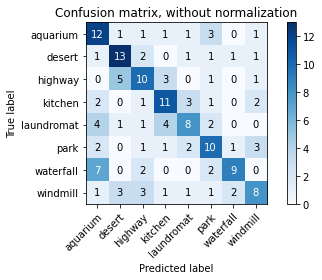

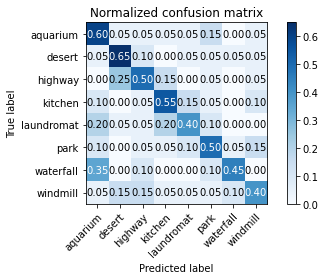

Confusion matrixes plotted.
accuracy score: 0.506
Accuracy calculated.
Execution done.


In [8]:
true,predictions = testModel(tes_path, kmeans, scale, svm, im_features, no_clusters, ker_type)

# Results

[ 27 129   8  74  60  63 158  21 114  43]


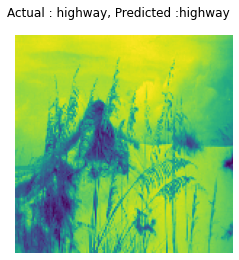

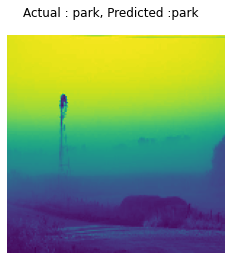

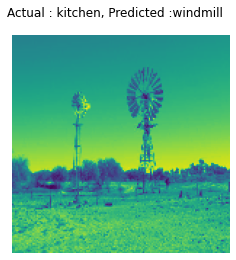

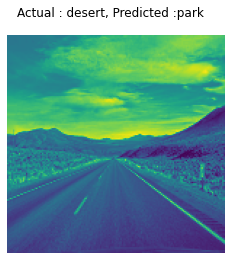

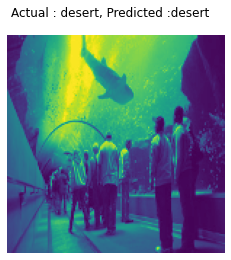

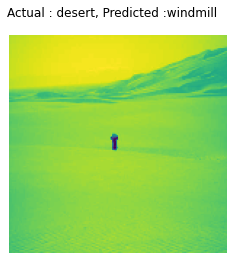

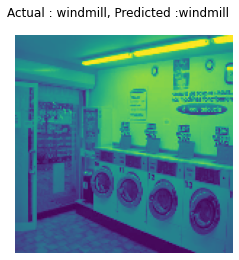

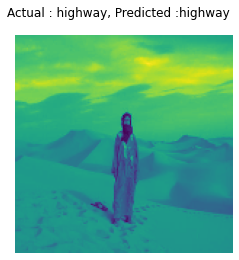

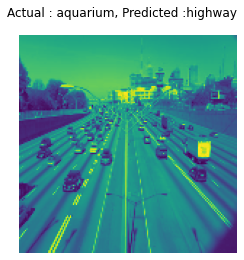

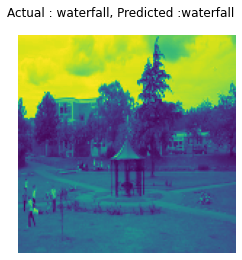

In [9]:
img_path = getFiles(True, tes_path)
i = np.arange(0,len(img_path))
random.shuffle(i)

print(i[:10])


for k in list(i[:10]):
    img = readImage(img_path[k])
    show_image(img, text='Actual : '+str(true[int(k)])+', Predicted :'+str(predictions[int(k)]))
